### Adapting GVP for arbitrary (proteins) point clouds

In [1]:
import os
import sys
import time
sys.path.append("../faster_nerf/mp_nerf")
sys.path.append("../geometric-vector-perceptron/geometric_vector_perceptron")

import torch
import numpy as np
from einops import rearrange, repeat
import matplotlib.pyplot as plt
# custom utils
from data_handler import *
from data_utils import *
# custom model
from geometric_vector_perceptron import *
# process and dataset
import gc
import joblib
from tqdm import tqdm
from functools import partial

In [2]:
# data
import sidechainnet
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cpu")

### Dataloader for training

In [ ]:
MAX_LEN = 120
MAX_PROTS = 4000

In [4]:
dataloaders_ = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders_.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
train_examples_storer = [get_prot(dataloader_=dataloaders_, vocab_=VOCAB, max_len=MAX_LEN, verbose=0) \
                        for i in tqdm(range(MAX_PROTS))]

# dataloaders won't work on my windows (idk why, so load examples from disk and train)
# train_examples_storer = joblib.load("sidechainnet_data/800_under_200.joblib")

## Data encoding dims and instantiate model

In [5]:
NEEDED_INFO = {"cutoffs": [2],
               "bond_scales": [0.5],
               "aa_pos_scales": [1,2,4,8,16,32,64,128],
               "atom_pos_scales": [1,2,4,8,16,32],
               "dist2ca_norm_scales": [1,2,4],
              }
# get model sizes from encoded protein
seq, true_coords, angles, padding_seq = train_examples_storer[-1] 

# encode as needed
encoded = encode_whole_protein(seq, true_coords, angles, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
x, edge_index, edge_attrs, embedd_info = encoded
embedd_info

{'point_n_vectors': 7,
 'point_n_scalars': 42,
 'bond_n_vectors': 2,
 'bond_n_scalars': 3,
 'bond_embedding_nums': [1]}

In [6]:
# define edge_attr recalculator
recalc_edge = partial(encode_whole_bonds, x_format = "prediction",
                                          embedd_info = embedd_info,
                                          needed_info = NEEDED_INFO,
                                          free_mem = True)
# define model
model = GVP_Network(n_layers=12, feats_x_in=42, vectors_x_in=7,
                                feats_x_out=42, vectors_x_out=7,
                                feats_edge_in=3, vectors_edge_in=2,
                                feats_edge_out=3, vectors_edge_out=2,
                                embedding_nums=[36, 20], embedding_dims=[16,16], # from _nums to _dims
                                edge_embedding_nums=[1], edge_embedding_dims=[2])

In [7]:
# calc training sample:
for th in [75, 90, 100, 120, 140]:
    print("under", th, "aas, we have:", sum([len(x[0])<th for x in train_examples_storer]), "proteins")

under 75 aas, we have: 0 proteins
under 90 aas, we have: 106 proteins
under 100 aas, we have: 225 proteins
under 120 aas, we have: 359 proteins
under 140 aas, we have: 478 proteins


### Train

In [8]:
model = model.to(device) # .double()

In [9]:
noise = 1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [24]:
model.train()

# info records
baseline_losses = []
epoch_losses    = []
tac    = time.time()
# training run params
max_seq_len = 120 # MAX_LEN
iteration   = 0
n_per_iter  = MAX_PROTS
for ep in range( 2*MAX_PROTS ):
    # get input data and target - copy to gpu
    seq, true_coords, angles, padding_seq = train_examples_storer[ep % len(train_examples_storer)]
    
    # avoid seqs above limit
    if len(seq) > max_seq_len: 
        continue
    true_coords = true_coords.to(device) # .double()
    angles = angles.to(device)           # .double()
    
    # mask sidechains to position of cbeta
    coords_wrap = rearrange(true_coords, '(l c) d -> l c d', c=14)
    coords_wrap[:, 4:] = repeat(coords_wrap[:, 4], 'l d -> l sc d', sc=10)
    trim_coords = rearrange(coords_wrap, 'l c d -> (l c) d', c=14)
    
    # target is the position of every atom (unit_vec, norm_scale)
    pre_target = encode_whole_protein(seq,
                                      true_coords,
                                      angles,
                                      padding_seq,
                                      needed_info=NEEDED_INFO, free_mem=True)
    pre_target_x, _, _, embedd_info = pre_target
    # encode as needed (noise mask)
    encoded = encode_whole_protein( seq,
                                    trim_coords + noise*torch.randn_like(true_coords),
                                    angles,
                                    padding_seq,
                                    needed_info=NEEDED_INFO, free_mem=True)
    x, edge_index, edge_attrs, embedd_info = encoded
    batch = torch.tensor([0 for i in range(x.shape[0])], device=device).long()
    
    # predict
    scores = model.forward(x, edge_index, batch=batch, edge_attr=edge_attrs,
                           recalc_edge=recalc_edge, verbose = False)
    # format pred, baseline and target
    target = from_encode_to_pred(pre_target_x, embedd_info, needed_info=NEEDED_INFO)
    pred   = from_encode_to_pred(scores, embedd_info, needed_info=NEEDED_INFO)
    base   = from_encode_to_pred(x, embedd_info, needed_info=NEEDED_INFO)
    
    # MEASURE ERROR
    
    # option 1: loss is MSE on output tokens
    # loss_ = (target-pred)**2
    # loss  = loss_.mean()
    
    # option 2: loss is RMSD on reconstructed coords
    pred_dec   = decode_dist(pred[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
    target_dec = decode_dist(target[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
    base_dec   = decode_dist(base[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
    # reconstruct coordinates
    target_coords = target[:, :3] * target_dec.unsqueeze(-1)
    pred_coords   = pred[:, :3] * pred_dec.unsqueeze(-1)
    base_coords   = base[:, :3] * base_dec.unsqueeze(-1)
    loss_base = ((base_coords - target_coords)**2).mean()**0.5
    loss = ((pred_coords - target_coords)**2).mean()**0.5
    
    # back pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ## free mem
    del true_coords, angles, pre_target_x, edge_index, edge_attrs
    del scores, pred_dec, target_dec, target_coords, pred_coords
    del encoded, pre_target
    gc.collect()
    
    # records / prints
    iteration += 1
    epoch_losses.append( loss.item() )
    baseline_losses.append( loss_base.item() )
    if iteration % 50 == 1:
        tic = time.time()
        print("BATCH: {0} / {1}, loss: {2}, baseline_loss: {3}, time: {4}".format(iteration, n_per_iter,
                                                                                  epoch_losses[-1],
                                                                                  baseline_losses[-1],
                                                                                  tic-tac))
        tac = time.time()
        if iteration % n_per_iter == 1:
            print("---------------------------------")

BATCH: 1 / 800, loss: 2.5815205574035645, baseline_loss: 1.1850024461746216, time: 0.2189955711364746
---------------------------------
BATCH: 51 / 800, loss: 2.05283522605896, baseline_loss: 1.177140474319458, time: 11.344528198242188
BATCH: 101 / 800, loss: 1.904536485671997, baseline_loss: 1.2103644609451294, time: 13.44109845161438
BATCH: 151 / 800, loss: 1.6417341232299805, baseline_loss: 1.2205429077148438, time: 12.359026432037354
BATCH: 201 / 800, loss: 1.3580347299575806, baseline_loss: 1.1018481254577637, time: 9.29105257987976
BATCH: 251 / 800, loss: 1.2299988269805908, baseline_loss: 1.1862484216690063, time: 9.299053430557251
BATCH: 301 / 800, loss: 1.2309552431106567, baseline_loss: 1.1676276922225952, time: 8.454373121261597
BATCH: 351 / 800, loss: 1.166231393814087, baseline_loss: 1.180825114250183, time: 9.286943197250366
BATCH: 401 / 800, loss: 1.073898434638977, baseline_loss: 1.138097882270813, time: 8.62497067451477
BATCH: 451 / 800, loss: 1.1140533685684204, basel

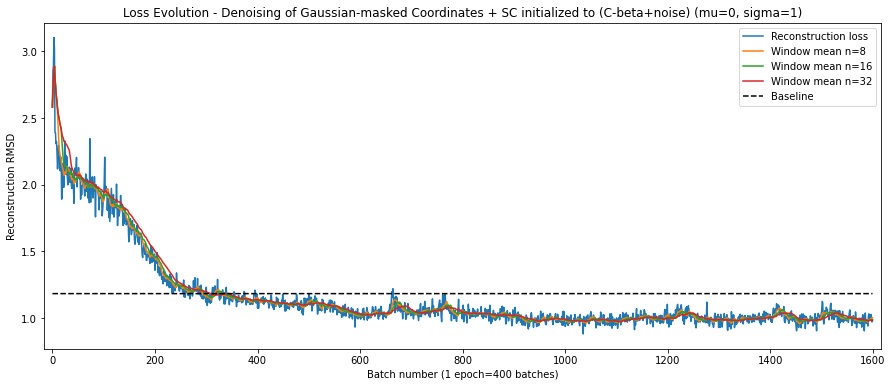

In [25]:
plt.figure(figsize=(15,6))
plt.title("Loss Evolution - Denoising of Gaussian-masked Coordinates + SC initialized to (C-beta+noise) (mu=0, sigma=1)")
plt.plot(epoch_losses, label="Reconstruction loss")

for window in [8,16,32]:
    plt.plot([np.mean(epoch_losses[:window][0:i+1]) for i in range(window)] + \
             [np.mean(epoch_losses[i:i+window+1]) for i in range(len(epoch_losses)-window)], 
             label="Window mean n={0}".format(window))

plt.plot(np.ones(len(epoch_losses))*np.mean(baseline_losses), "k--", label="Baseline")
    
# plt.yscale("log")
plt.xlim(-0.01*len(epoch_losses),1.01*len(epoch_losses))
plt.ylabel("Reconstruction RMSD")
plt.xlabel("Batch number (1 epoch=400 batches)")
plt.legend()
plt.show()

### Measure rmsd on (the last trained) reconstructed protein

* Not passing through the model

In [26]:
unfiltered = from_encode_to_pred(x, embedd_info, needed_info=NEEDED_INFO)
# smaple decoded distance test
unfiltered_dec = decode_dist(unfiltered[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
target_dec     = decode_dist(target[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
# mean of diffs is same as diff of means
print("MSE between norms of vecs: ", ((unfiltered_dec - target_dec)**2).mean() ) 
# reconstruct coordinates
target_coords = target[:, :3] * target_dec.unsqueeze(-1)
unfiltered_coords = unfiltered[:, :3] * unfiltered_dec.unsqueeze(-1)
print("MSE between reconstructed coords: ", ((unfiltered_coords - target_coords)**2).mean()**0.5 ) 

MSE between norms of vecs:  tensor(4.2167, device='cuda:0')
MSE between reconstructed coords:  tensor(1.2171, device='cuda:0')


* passing through the model

In [27]:
# smaple decoded distance test
sample_pred_dec = decode_dist(pred[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
target_dec      = decode_dist(target[:, 3:], scales=NEEDED_INFO["atom_pos_scales"]).mean(dim=-1)
# mean of diffs is same as diff of means
print("MSE between norms of vecs: ", ((sample_pred_dec - target_dec)**2).mean() ) 
# reconstruct coordinates
target_coords = target[:, :3] * target_dec.unsqueeze(-1)
sample_pred_coords = pred[:, :3] * sample_pred_dec.unsqueeze(-1)
print("RMSD between reconstructed coords: ", ((sample_pred_coords - target_coords)**2).mean()**0.5 )

MSE between norms of vecs:  tensor(3.1738, device='cuda:0', grad_fn=<MeanBackward0>)
RMSD between reconstructed coords:  tensor(0.9862, device='cuda:0', grad_fn=<PowBackward0>)


### Record Expected Error without model

In [28]:
np.mean(baseline_losses) # recorded inside training loop

1.1829248958081007

### Make a plot of a reconstructed protein

In [50]:
scaffs  = build_scaffolds_from_scn_angles(seq[:-padding_seq], angles[:-padding_seq].cpu())
wrapper = torch.zeros(*scaffs["cloud_mask"].shape, 3).cpu()
# rebuild
pred_rebuilt = wrapper[:]
pred_rebuilt[scaffs["cloud_mask"].cpu()] = sample_pred_coords.cpu()
# target_rebuild
target_rebuilt = wrapper[:]
target_rebuilt[scaffs["cloud_mask"].cpu()] = target_coords.cpu()

In [51]:
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(target_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [52]:
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(pred_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol